# Import Libraries

In [1]:
import os
import random
import sys
from datetime import datetime
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Datasets

In [3]:
BATCH_SIZE = 128

## Data Augmentations

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.Normalize(mean, std),
    T.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2))
])

val_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

## DataSet and DataLoader

In [5]:
fer_2013_dir = Path(os.getcwd(), 'datasets', 'fer2013')

In [6]:
training_set = ImageFolder(root=fer_2013_dir / 'train', transform=train_transforms)
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = ImageFolder(root=fer_2013_dir / 'test', transform=val_transforms)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Print shape of training and testing images
print(f"Training set: {len(training_set)} images")
print(f"Testing set: {len(test_set)} images")

for images, labels in training_loader:
  break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

Training set: 28709 images
Testing set: 7178 images
One image batch shape : torch.Size([128, 3, 48, 48])
One label batch shape : torch.Size([128])


In [8]:
print(training_set.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [9]:
label_map = {
    0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 
    4: 'neutral', 5: 'sad', 6: 'surprise'
}

#### Show sample images

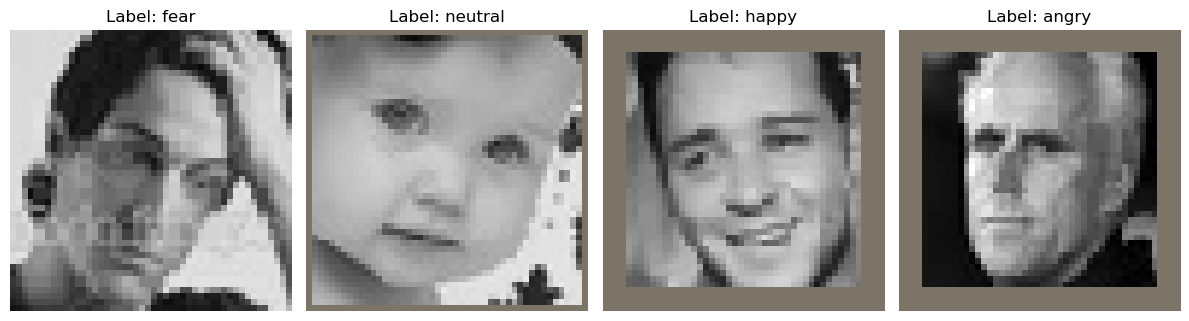

In [10]:
# Get a batch
images, labels = next(iter(training_loader))

# Unnormalize a few images from the batch
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Display first 4 images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(4):
    img = unnormalize(images[i])
    img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label_map[int(labels[i])]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# ResNet50 Model

### Define Class & Compile Model

In [11]:
params={          
        "dropout_rate": 0.2,
        "num_classes": 7,
}

resnet50_fer_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50_fer_model.fc = nn.Sequential(
    nn.Dropout(params["dropout_rate"]),
    nn.Linear(resnet50_fer_model.fc.in_features, params["num_classes"])
)
resnet50_fer_model = resnet50_fer_model.to(device)

In [12]:
print(summary(resnet50_fer_model, input_size=(BATCH_SIZE, 3, 48, 48), device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 7]                  --
├─Conv2d: 1-1                            [128, 64, 24, 24]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 24, 24]         128
├─ReLU: 1-3                              [128, 64, 24, 24]         --
├─MaxPool2d: 1-4                         [128, 64, 12, 12]         --
├─Sequential: 1-5                        [128, 256, 12, 12]        --
│    └─Bottleneck: 2-1                   [128, 256, 12, 12]        --
│    │    └─Conv2d: 3-1                  [128, 64, 12, 12]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 12, 12]         128
│    │    └─ReLU: 3-3                    [128, 64, 12, 12]         --
│    │    └─Conv2d: 3-4                  [128, 64, 12, 12]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 12, 12]         128
│    │    └─ReLU: 3-6                    [128, 64, 12, 12]         --
│ 

# Create Train and Test functions

### Define functions

In [13]:
def calculate_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1, dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.cuda.FloatTensor))

In [14]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, current_epoch, epochs):
    """
    Train one epoch of the model.

    Args:
        model (nn.Module): The  model.
        dataloader (DataLoader): DataLoader for training data.
        device (torch.device): Device to train the model on (CPU/GPU).

    Returns:
        training_loss (float): Returns epoch_loss / len(dataloader)
    """
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(epochs))

    for t, data in enumerate(tk):
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Compute log probabilities from model
        logits = model(images)
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss for logging; Total loss
        epoch_loss += loss.item()
        
        epoch_accuracy += calculate_accuracy(logits, labels)

        # Print/log training loss and accuracy for this epoch
        tk.set_postfix({
            'loss': '%6f' % float(epoch_loss / (t + 1)), 
            'acc': '%6f' % float(epoch_accuracy / (t + 1))
        })

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [15]:
def test_one_epoch(model, dataloader, criterion, device, current_epoch, epochs):
    """
    Test one epoch of the model

    Args:
        model (nn.Module): The model.
        dataloader (DataLoader): DataLoader for training data.
        learning_rate (float): Learning rate for optimizer.
        device (torch.device): Device to train the model on (CPU/GPU).

    Returns:
        training_loss (float): Returns epoch_loss / len(dataloader)
        
        running_acc (float): Returns epoch accuracy
    """
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(epochs))

    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for testing
        for t, data in enumerate(tk):          
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # Compute log probabilities from model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)            

            # Compute CTC loss
            loss = criterion(logits, labels)

            # Accumulate loss for logging; Total loss
            epoch_loss += loss.item()
            
            epoch_accuracy += calculate_accuracy(logits, labels)
            

            tk.set_postfix({
                'loss': '%6f' % float(epoch_loss / (t + 1)), 
                'acc': '%6f' % float(epoch_accuracy / (t + 1))
            })

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [16]:
def train_and_validate_model(model, training_dataloader, testing_dataloader, epochs, learning_rate, device):
    """
    Train and Test the speech recognition model using CTC loss.

    Args:
        model (nn.Module): The model.
        training_dataloader (DataLoader): DataLoader for training data.
        testing_dataloader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for optimizer.
        device (torch.device): Device to train the model on (CPU/GPU).
    """
    # Define Loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

    # Move model to device
    model.to(device)

    best_valid_loss = np.inf
    patience_counter = 0   # Tracks the number of epochs without improvement
    early_stop = False # Flag to indicate whether to stop training
    save_weights_patience = 3

    # Dictionary to store loss and accuracy values over epochs
    history_metrics = {
        'training_loss': [],
        'training_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }

    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered. Stopping training.")
            break

        print(f"Epoch {epoch + 1}, LR: {scheduler.optimizer.param_groups[0]['lr']}")

        # Training step
        train_loss, train_accuracy = train_one_epoch(model, training_dataloader, criterion, optimizer, device, epoch, epochs)
        
        # Testing step
        valid_loss, valid_accuracy = test_one_epoch(model, testing_dataloader, criterion, device, epoch, epochs) 

        history_metrics['training_loss'].append(train_loss)
        history_metrics['validation_loss'].append(valid_loss)
        history_metrics['training_accuracy'].append(train_accuracy)
        history_metrics['validation_accuracy'].append(valid_accuracy)

        # Update the learning rate based on validation loss and print
        scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), 'weights/RESNET50_model_with_fer2013_weights.pt')
            print("SAVED-BEST-WEIGHTS!")
            best_valid_loss = valid_loss
            patience_counter = 0 # Reset early stopping
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= save_weights_patience:
            print("Patience exceeded. Early stopping at epoch " +str(epoch + 1))
            early_stop = True
            
        
    print("")
    return history_metrics

### Run train functions

In [ ]:
time1 = datetime.now()

In [17]:
# Train the model:
resnet_model_losses = train_and_validate_model(resnet50_fer_model, training_loader, test_loader, epochs=100, learning_rate=0.001, device=device)

Epoch 1, LR: 0.001


EPOCH[TRAIN]1/100:   9%|▉         | 20/225 [00:10<01:47,  1.91it/s, loss=1.973859, acc=0.158984]


KeyboardInterrupt: 

> TRained for about 50 + 14 epochs

In [ ]:
time2 = datetime.now()
print("Training time: ", time2 - time1)

In [ ]:
# Prepare the data
data = {
    "Epoch": list(range(1, len(resnet_model_losses['training_loss']) + 1)),
    "Training Loss": resnet_model_losses['training_loss'],
    "Validation Loss": resnet_model_losses['validation_loss'],
    "Training Accuracy": resnet_model_losses['training_accuracy'],
    "Validation Accuracy": resnet_model_losses['validation_accuracy']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("base_model_stats_5_layers.csv", index=False)
print("Losses and accuracy saved to losses_and_accuracy.csv")

# FSL DA Prototypical Network

### Dataset class

In [ ]:
class FewShotFERDataset(Dataset):
    """
    Dataset for few-shot FER, where images are organized by class in folders.
    This dataset generates episodes (tasks) on-the-fly.
    """
    def __init__(self, root_dir, n_way=5, k_shot=1, k_query=5, transform=None):
        """
        root_dir: Root folder containing one folder per class.
        n_way: number of classes per episode.
        k_shot: number of support examples per class.
        k_query: number of query examples per class.
        transform: transformation to apply to images.
        """
        self.root_dir = root_dir
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.transform = transform
        
        # Build a mapping: class -> list of image paths.
        self.class_to_imgs = {}
        for cls_name in os.listdir(root_dir):
            cls_folder = Path.joinpath(root_dir, cls_name)
            if Path.is_dir(cls_folder):
                self.class_to_imgs[cls_name] = [Path.joinpath(cls_folder, img)                                                 
                                                 for img in Path(cls_folder).rglob('*')
                                                 if img.endswith('.jpg') or img.endswith('.png')]        
        self.classes = list(self.class_to_imgs.keys())
    
    def __len__(self):
        # Define the number of episodes arbitrarily.
        return 1000  # or any number representing episodes
    
    def __getitem__(self, idx):
        # Randomly sample n_way classes for this episode.
        sampled_classes = random.sample(self.classes, self.n_way)
        support_imgs, support_labels = [], []
        query_imgs, query_labels = [], []
        
        label_map = {cls_name: i for i, cls_name in enumerate(sampled_classes)}
        
        for cls_name in sampled_classes:
            imgs = self.class_to_imgs[cls_name]
            # Ensure there are enough examples in this class.
            selected_imgs = random.sample(imgs, self.k_shot + self.k_query)
            support_paths = selected_imgs[:self.k_shot]
            query_paths = selected_imgs[self.k_shot:]
            
            for sp in support_paths:
                img = Image.open(sp).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_imgs.append(img)
                support_labels.append(label_map[cls_name])
            
            for qp in query_paths:
                img = Image.open(qp).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_imgs.append(img)
                query_labels.append(label_map[cls_name])
        
        # Convert lists to tensors.
        support_imgs = torch.stack(support_imgs)  # shape: [n_way*k_shot, C, H, W]
        support_labels = torch.tensor(support_labels, dtype=torch.long)
        query_imgs = torch.stack(query_imgs)      # shape: [n_way*k_query, C, H, W]
        query_labels = torch.tensor(query_labels, dtype=torch.long)
        
        return (support_imgs, support_labels), (query_imgs, query_labels)

### Constructing DataLoader

In [ ]:
# Define transforms (should match what the encoder expects)
transform = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Root folder with classes as subfolders.
few_shot_dataset = FewShotFERDataset(root_dir="path/to/FER_few_shot", n_way=5, k_shot=1, k_query=5, transform=transform)
few_shot_loader = DataLoader(few_shot_dataset, batch_size=1, shuffle=True, num_workers=4)


### Prototypical Network Inference function

In [ ]:
def evaluate_episode(model, support_imgs, support_labels, query_imgs, query_labels, device):
    """
    model: the fine-tuned FER model, used as feature extractor.
    support_imgs: [n_way*k_shot, C, H, W]
    query_imgs: [n_way*k_query, C, H, W]
    support_labels: [n_way*k_shot]
    query_labels: [n_way*k_query]
    """
    model.eval()
    with torch.no_grad():
        support_imgs = support_imgs.to(device)
        query_imgs = query_imgs.to(device)
        
        # Extract features using the pretrained encoder.
        # We assume the encoder returns a [B, 1 + num_patches, D] tensor and we use the CLS token.
        def get_cls_features(x):
            tokens = model.encoder(x)  # shape: [B, 1 + num_patches, D]
            return tokens[:, 0, :]     # extract CLS token
        
        support_feats = get_cls_features(support_imgs)  # shape: [n_way*k_shot, D]
        query_feats = get_cls_features(query_imgs)      # shape: [n_way*k_query, D]
        
        # Compute prototypes: mean feature for each class.
        n_way = len(torch.unique(support_labels))
        prototypes = []
        for cls in range(n_way):
            cls_indices = (support_labels == cls).nonzero(as_tuple=True)[0]
            cls_feats = support_feats[cls_indices]
            prototype = cls_feats.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)  # shape: [n_way, D]
        
        # Compute distances between each query feature and prototypes.
        # We'll use Euclidean distance.
        # Expand dimensions: query_feats: [Q, 1, D] and prototypes: [1, n_way, D]
        dists = torch.cdist(query_feats, prototypes, p=2)  # shape: [n_way*k_query, n_way]
        
        # Convert distances to probabilities with a softmax on negative distances.
        probs = F.softmax(-dists, dim=1)  # lower distance = higher probability
        
        # Predictions: class with the highest probability.
        preds = torch.argmax(probs, dim=1)
        correct = (preds.cpu() == query_labels).sum().item()
        total = query_labels.size(0)
    
    return correct, total


### Run inference

In [ ]:
# ------------------------------------------
# Evaluate on a few episodes from the DataLoader
# ------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assume model_fer is the fine-tuned FER model we defined previously.
model_fer = model_fer.to(device)
total_correct = 0
total_samples = 0
num_episodes = 50  # Evaluate on 50 episodes for instance.

for i, ((support_imgs, support_labels), (query_imgs, query_labels)) in enumerate(few_shot_loader):
    if i >= num_episodes:
        break
    correct, total = evaluate_episode(model_fer, support_imgs.squeeze(0), support_labels.squeeze(0),
                                      query_imgs.squeeze(0), query_labels.squeeze(0), device)
    total_correct += correct
    total_samples += total

episode_accuracy = 100.0 * total_correct / total_samples
print("Few-Shot Episode Accuracy: {:.2f}%".format(episode_accuracy))